In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
 block_size = 3

 def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
 # MLP revisited
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embed))
W1 = torch.randn((n_embed * block_size, n_hidden)) * 0.01
b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(vocab_size) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

11897


In [8]:
max_steps = 200_000
batch_size = 32
i_loss = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors
  h_pre_act = emb_cat @ W1 + b1
  h = torch.tanh(h_pre_act) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 10000 else 0.01 # learning rate annealing
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10_000 == 0:
    print("{} / {} : {}".format(i, max_steps, loss.item()))
  i_loss.append(loss.item())

  # break


0 / 200000 : 3.2962636947631836
10000 / 200000 : 2.3596787452697754
20000 / 200000 : 2.0016770362854004
30000 / 200000 : 2.1043624877929688
40000 / 200000 : 2.0048413276672363
50000 / 200000 : 1.8962955474853516
60000 / 200000 : 2.4636268615722656
70000 / 200000 : 2.0949273109436035
80000 / 200000 : 2.3044869899749756
90000 / 200000 : 2.2556731700897217
100000 / 200000 : 2.441678762435913
110000 / 200000 : 2.3191235065460205
120000 / 200000 : 2.3263609409332275
130000 / 200000 : 2.0170116424560547
140000 / 200000 : 1.9965481758117676
150000 / 200000 : 2.038499593734741
160000 / 200000 : 1.8886890411376953
170000 / 200000 : 2.25991153717041
180000 / 200000 : 2.1801440715789795
190000 / 200000 : 2.140237331390381


In [9]:
# plt.hist(h.view(-1).tolist(), 50);
# plt.hist(h_pre_act.view(-1).tolist(), 50);
# plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest', aspect='auto')

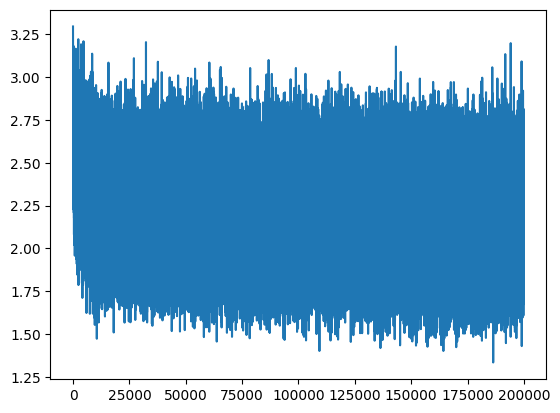

In [10]:
plt.plot(i_loss)

In [11]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embed)
  emb_cat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
  h_pre_act = emb_cat @ W1 + b1
  h = torch.tanh(h_pre_act)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1444363594055176
val 2.166780471801758


In [12]:
for _ in range(20):
  out = []
  context  = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    emb_cat = emb.view(emb.shape[0], -1)
    h_pre_act = emb_cat @ W1 + b1
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

mazmassya.
jella.
haymi.
nathat.
bryla.
ameron.
anniqued.
averrigleruer.
kashi.
cyn.
adaree.
mildan.
nockie.
tivianaan.
mamibremhavikhaliza.
kortah.
daxsleigh.
myah.
masurmina.
maciam.


There are few things wrong with things here.

- Our initilisation is wrong. We start with high error which decreases way too quickly
 - When we start we can roughly estimate the loss.
 - For example in this case, we can expect that all characters have equal probability to occur in beginning. And this would give low loss
 - ```
 logits = torch.tensor([1.0, 5.0, 0.0, 10.0])
 probs = torch.softmax(logits, dim = 0)
 loss = -probs[2].log
 logits, probs, loss
 ```
 - We can't set Ws to be zero. You want them to be small but not zero. Things can go wrong
 - Doing this and our loss won't look like hockey stick. This is true for all NNs
 - **Fix** : We removed bias by multip;ying to zero. We multiplied Ws by 0.1 to reduce them.
- If we visualise `h` we see that we have too many 1s and -1s and that is because our `h` is tanh and it acts as squashing force.
 - Way to check: `plt.hist(h.view(-1).tolist(), 50);`
 - It is very active. Look at h_pre_act and you see it is very broad.
 - This is "sweating" situation for person who is training method.
 - Backward prop for tanh is `(1-t**2) * out.grad`. If outputs for t are very close to 1 or -1; we will get zero. No matter what out.grad is we are killing and basically stopping the propagation here.
 - Change input is not going to impact the output too much because if it is in flat region of tanh; there is no impact on the loss.
 - The gradient flowing through tanh can only ever decrease.
 - ```
 plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest', aspect='auto')
 ```
 - In above code you should see no column which is completely white. That represents dead neuron since you are just passing the out.grad and nothing is happening there.
 - So both of above cases, makes it that neuron never learns from here.
 - This is true for a lot of activation functions.
 - If it happens during learning, think of it as some permanent brain damage in network
 - This is happening because `h_pre_act` has very diverse values.
 - **Fix**: Same as above. We squash our inital weights and biases.

**Deeper the network is, more complex the network is the less forgiving initialisation is. The inconsistency keeps stacking up and may almost result in non-traning of network**


_But how do I come with this squashing magic numbers?_

tensor(-0.0153) tensor(1.0012)
tensor(0.0069) tensor(3.0969)
tensor(0.0092) tensor(0.9925)
tensor(0.0004) tensor(1.0008)


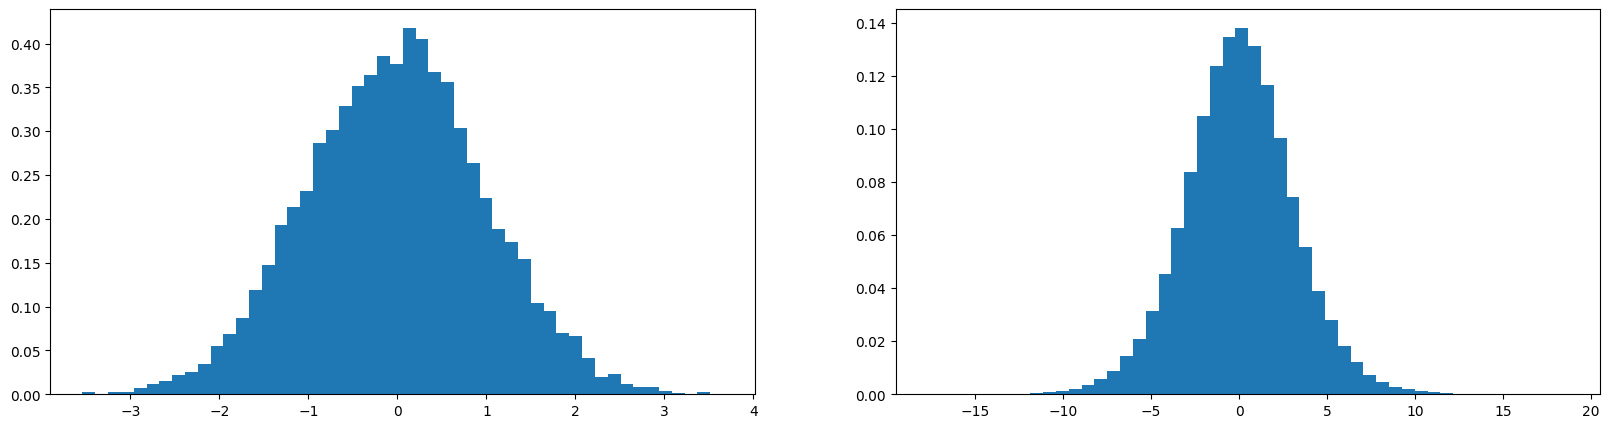

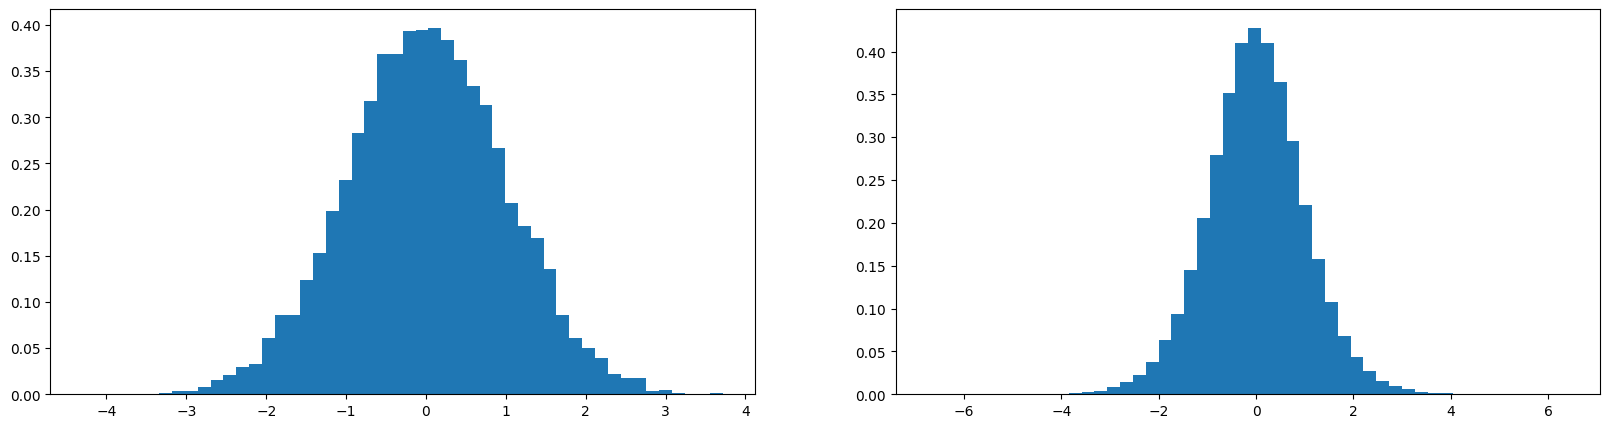

In [13]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

# the correct answer if we do the maths for y and work backwards is
# dividing by square_root(fan_in) where fan_in is number of inputs.

x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);


# Read: https://arxiv.org/pdf/1502.01852
# https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_
# probably the most used init for nns

# Batch Normalisation
https://arxiv.org/pdf/1502.03167

In [14]:
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embed))
W1 = torch.randn((n_embed * block_size, n_hidden)) * (5/3) / (n_embed * block_size)**0.5
b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, vocab_size)) * (5/3) / (n_hidden + vocab_size)**0.5
b2 = torch.randn(vocab_size) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# declare this after understanding about running mean and standard deviation
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

12297


In [15]:
max_steps = 200_000
batch_size = 32
i_loss = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors
  h_pre_act = emb_cat @ W1 + b1
  h_pre_act = bngain * (h_pre_act - h_pre_act.mean(0, keepdim=True)) / h_pre_act.std(0, keepdim=True) + bnbias # normalise
  h = torch.tanh(h_pre_act) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 10000 else 0.01 # learning rate annealing
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10_000 == 0:
    print("{} / {} : {}".format(i, max_steps, loss.item()))
  i_loss.append(loss.item())

  # break

0 / 200000 : 3.583409070968628
10000 / 200000 : 2.441131353378296
20000 / 200000 : 2.4654951095581055
30000 / 200000 : 2.165614128112793
40000 / 200000 : 1.978386402130127
50000 / 200000 : 2.0218253135681152
60000 / 200000 : 2.4288089275360107
70000 / 200000 : 1.5585486888885498
80000 / 200000 : 2.2893223762512207
90000 / 200000 : 2.2303991317749023
100000 / 200000 : 2.2161710262298584
110000 / 200000 : 1.9000117778778076
120000 / 200000 : 2.1515939235687256
130000 / 200000 : 2.110975503921509
140000 / 200000 : 2.0501246452331543
150000 / 200000 : 2.6252353191375732
160000 / 200000 : 1.9064186811447144
170000 / 200000 : 2.3316807746887207
180000 / 200000 : 2.450584650039673
190000 / 200000 : 2.1018929481506348


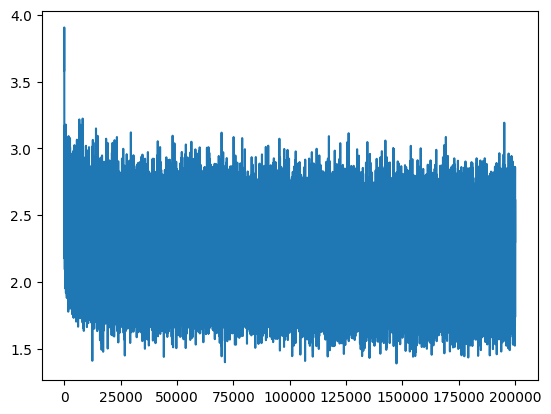

In [16]:
plt.plot(i_loss)

In [17]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embed)
  emb_cat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
  h_pre_act = emb_cat @ W1 + b1
  h_pre_act = bngain * (h_pre_act - h_pre_act.mean(0, keepdim=True)) / h_pre_act.std(0, keepdim=True) + bnbias # normalise
  h = torch.tanh(h_pre_act)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.113398790359497
val 2.139758825302124


The stability provided by batch normalization comes with certain trade-offs and introduces an unconventional dynamic to the neural network's behavior. Traditionally, when processing a single example through a neural network, we calculate activations and logits independently. To enhance efficiency, we began processing examples in batches, treating these batches as independent collections purely for computational optimization.

However, batch normalization changes this paradigm by mathematically coupling examples within a batch during both the forward and backward passes of the network. As a result, the hidden state activations (h_pre_act) and logits for any single input are no longer solely determined by that input alone. Instead, they are influenced by the other examples present in the same batch, which are typically selected randomly.

This means the value of h_pre_act, which feeds into the hidden state activations, will vary slightly depending on the composition of the batch. This might initially seem counterintuitive or even like a flaw in the design. However, this coupling acts as a form of implicit regularization, preventing the network from overfitting by encouraging it to generalize across varied batch compositions.

In essence, while batch normalization introduces a dependency between examples in a batch, this interaction turns out to be beneficial for the network's performance and robustness.

In [18]:
# Since, in production when model is deployed we need to run a single set of input
# but our model expects batch which is not true, we set it once.

# calibrating the batch norm at the end of training
with torch.no_grad():
  emb = C[Xtr]
  emb_cat = emb.view(emb.shape[0], -1)
  h_pre_act = emb_cat @ W1 + b1
  bnmean = h_pre_act.mean(0, keepdim=True)
  bnstd = h_pre_act.std(0, keepdim=True)

# nobody wants to do above
# no-one wants to have an additional step after training
# we can do this in running manner

In [19]:
max_steps = 200_000
batch_size = 32
i_loss = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors
  h_pre_act = emb_cat @ W1 + b1
  bnmeani = h_pre_act.mean(0, keepdim=True)
  bnstdi = h_pre_act.std(0, keepdim=True)
  h_pre_act = bngain * (h_pre_act - bnmeani) / bnstdi + bnbias # normalise

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(h_pre_act) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 10000 else 0.01 # learning rate annealing
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10_000 == 0:
    print("{} / {} : {}".format(i, max_steps, loss.item()))
  i_loss.append(loss.item())

  # break

0 / 200000 : 2.056952476501465
10000 / 200000 : 2.3882834911346436
20000 / 200000 : 2.0278472900390625
30000 / 200000 : 2.279096841812134
40000 / 200000 : 1.8954967260360718
50000 / 200000 : 2.1460602283477783
60000 / 200000 : 1.8205275535583496
70000 / 200000 : 2.1840553283691406
80000 / 200000 : 2.1120920181274414
90000 / 200000 : 1.6831337213516235
100000 / 200000 : 2.3327410221099854
110000 / 200000 : 2.130119562149048
120000 / 200000 : 2.2303850650787354
130000 / 200000 : 2.768557548522949
140000 / 200000 : 1.909378170967102
150000 / 200000 : 1.8780277967453003
160000 / 200000 : 1.9210437536239624
170000 / 200000 : 2.3753128051757812
180000 / 200000 : 1.8508961200714111
190000 / 200000 : 2.2037882804870605


In [20]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embed)
  emb_cat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
  h_pre_act = emb_cat @ W1 + b1
  # h_pre_act = bngain * (h_pre_act - h_pre_act.mean(0, keepdim=True)) / h_pre_act.std(0, keepdim=True) + bnbias # normalise
  h_pre_act = bngain * (h_pre_act - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(h_pre_act)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0813910961151123
val 2.1190927028656006


In [21]:
for _ in range(20):
  out = []
  context  = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    emb_cat = emb.view(emb.shape[0], -1)
    h_pre_act = emb_cat @ W1 + b1
    h_pre_act = bngain * (h_pre_act - bnmean) / bnstd + bnbias
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

viong.
drensriggsira.
jetzamarvin.
zah.
tibe.
rawn.
kahmin.
wylyn.
jaria.
kamri.
kim.
merendron.
darrandriah.
lucylian.
weshunah.
tianghan.
kharmanva.
adalle.
madtucc.
janiyah.


We are being little wasteful here.

`h_pre_act = emb_cat @ W1 + b1`

b1 aka the bias is useless here. We are takeing a mean later and subtracing it.
It has not effect. If you look at b1.grad(); it will be zero.
bnbias is actually taking care of bias now.

In [22]:
# Bringing everything together till now

n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embed))
W1 = torch.randn((n_embed * block_size, n_hidden)) * (5/3) / (n_embed * block_size)**0.5
W2 = torch.randn((n_hidden, vocab_size)) * (5/3) / (n_hidden + vocab_size)**0.5

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# declare this after understanding about running mean and standard deviation
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

max_steps = 200_000
batch_size = 32
i_loss = []

for i in range(max_steps):

  # mini batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y


  # forward pass
  emb = C[Xb] # embed the characters into vectors
  emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # linear layer
  h_pre_act = emb_cat @ W1
  # batch norm layer
  bnmeani = h_pre_act.mean(0, keepdim=True)
  bnstdi = h_pre_act.std(0, keepdim=True)
  h_pre_act = bngain * (h_pre_act - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # end of batch norm
  # non linearity
  h = torch.tanh(h_pre_act) # hidden layer
  logits = h @ W2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function


  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 10000 else 0.01 # learning rate annealing
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10_000 == 0:
    print("{} / {} : {}".format(i, max_steps, loss.item()))
  i_loss.append(loss.item())

@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embed)
  emb_cat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
  h_pre_act = emb_cat @ W1
  h_pre_act = bngain * (h_pre_act - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(h_pre_act)
  logits = h @ W2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

12070
0 / 200000 : 3.9686996936798096
10000 / 200000 : 2.4554190635681152
20000 / 200000 : 2.2762138843536377
30000 / 200000 : 2.2376060485839844
40000 / 200000 : 1.8600516319274902
50000 / 200000 : 2.040330410003662
60000 / 200000 : 2.2793474197387695
70000 / 200000 : 1.943544626235962
80000 / 200000 : 2.0313079357147217
90000 / 200000 : 2.1820619106292725
100000 / 200000 : 2.120480537414551
110000 / 200000 : 2.0528244972229004
120000 / 200000 : 2.135965347290039
130000 / 200000 : 2.4176104068756104
140000 / 200000 : 1.9799611568450928
150000 / 200000 : 1.9785733222961426
160000 / 200000 : 1.6534509658813477
170000 / 200000 : 2.4656760692596436
180000 / 200000 : 1.9532902240753174
190000 / 200000 : 2.243013858795166
train 2.114193916320801
val 2.145355701446533


# Deeper network and summary

In [33]:
# Let us train a deeper network

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      x_mean = x.mean(0, keepdim=True) # batch mean
      x_var = x.var(0, keepdim=True) # batch variance
    else:
      x_mean = self.running_mean
      x_var = self.running_var
    x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps) # normalise to unit variance
    self.out = self.gamma * x_hat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]


class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []


n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

# Do not start with BatchNorn
C = torch.randn((vocab_size, n_embed))
layers = [
    Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  # layers[-1].weight *= 0.
  layers[-1].gamma *= 0.1
  # for all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5 / 3 # we can play with this to see how it impact things

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [24]:
# same optimisation technique as last time

max_steps = 200_000
batch_size = 32

i_loss = []
update_to_data_ratio = []

for i in range(max_steps):

  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    emb_cat = layer(emb_cat)
  loss = F.cross_entropy(emb_cat, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 10000 else 0.01 # learning rate annealing
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10_000 == 0:
    print("{} / {} : {}".format(i, max_steps, loss.item()))
  i_loss.append(loss.log10().item())
  with torch.no_grad():
    update_to_data_ratio.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # After_DEBUG: remove to run full optimisation

0 / 200000 : 3.2695438861846924


layer 1 (Tanh): mean -0.028329605236649513, std 0.7660464644432068, saturated 0.2224999964237213
layer 4 (Tanh): mean 0.005190019495785236, std 0.6389439702033997, saturated 0.030625000596046448
layer 7 (Tanh): mean 0.0029556602239608765, std 0.6457549333572388, saturated 0.029999999329447746
layer 10 (Tanh): mean -0.0072426642291247845, std 0.6526957154273987, saturated 0.026249999180436134
layer 13 (Tanh): mean -0.007112300489097834, std 0.6608690023422241, saturated 0.020937500521540642


Text(0.5, 1.0, 'output distribution')

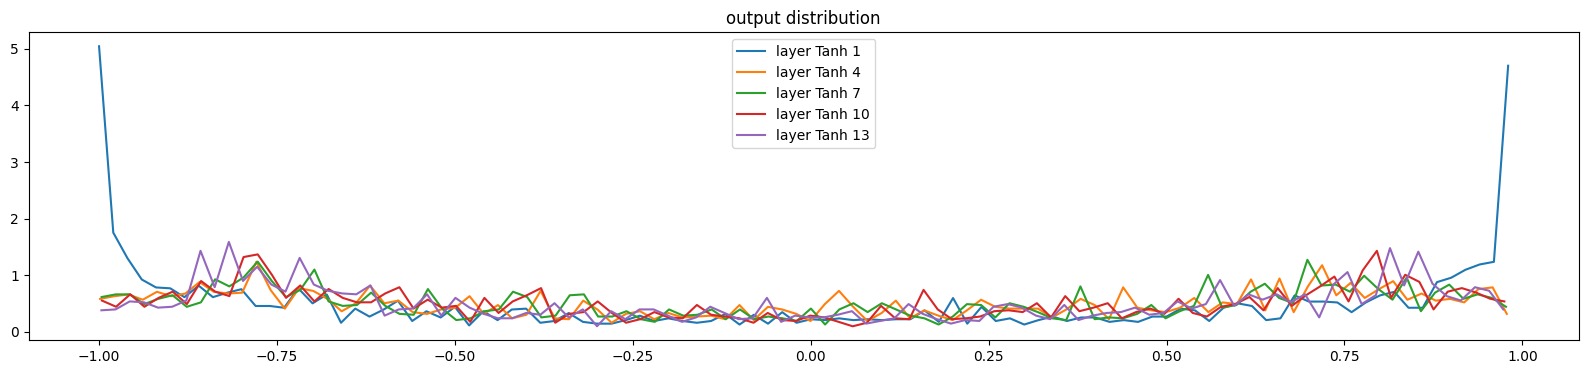

In [27]:
# visualize histograms forward pass

plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers):
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer {} ({}): mean {}, std {}, saturated {}'.format(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append('layer {} {}'.format(layer.__class__.__name__, i))
plt.legend(legends)
plt.legend(legends)
plt.title('output distribution')

layer 1 (Tanh): mean -1.4551915228366852e-11, std 0.004404657986015081
layer 4 (Tanh): mean -1.1641532356165829e-11, std 0.003776577766984701
layer 7 (Tanh): mean -3.492459576745488e-12, std 0.0031542356591671705
layer 10 (Tanh): mean -4.656612768993984e-12, std 0.0028941172640770674
layer 13 (Tanh): mean -1.1641532356165829e-11, std 0.0029061760287731886


Text(0.5, 1.0, 'gradient distribution')

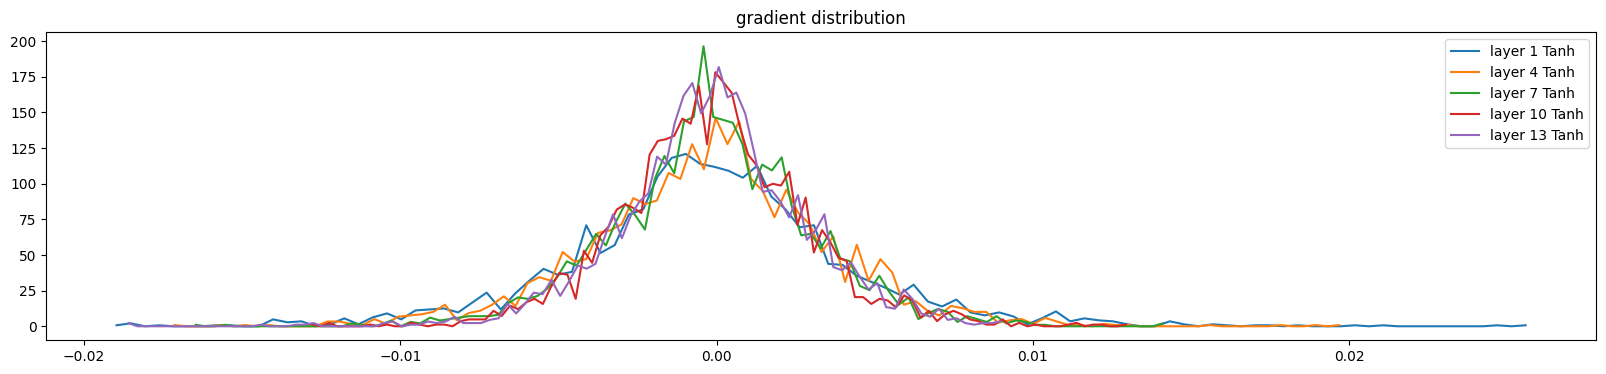

In [26]:
# visualize histogram backward pass

plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer {} ({}): mean {}, std {}'.format(i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append('layer {} {}'.format(i, layer.__class__.__name__))
plt.legend(legends)
plt.title('gradient distribution')

layer 0 (torch.Size([27, 10])): mean 0.00010005583317251876, std 0.010756602510809898, grad:data raptio 0.06511891633272171
layer 1 (torch.Size([30, 100])): mean 0.0001518685312476009, std 0.009047399275004864, grad:data raptio 0.1617504507303238
layer 3 (torch.Size([100, 100])): mean -4.127546344534494e-05, std 0.007116387598216534, grad:data raptio 0.35758137702941895
layer 7 (torch.Size([100, 100])): mean -5.203871114645153e-05, std 0.006462994497269392, grad:data raptio 0.21221327781677246
layer 11 (torch.Size([100, 100])): mean 7.841108163120225e-05, std 0.005684490315616131, grad:data raptio 0.32370367646217346
layer 15 (torch.Size([100, 100])): mean 2.6896013878285885e-06, std 0.0059038312174379826, grad:data raptio 0.24735869467258453
layer 19 (torch.Size([100, 27])): mean -0.00036551611265167594, std 0.012108671478927135, grad:data raptio 0.1909654438495636


Text(0.5, 1.0, 'gradient distribution')

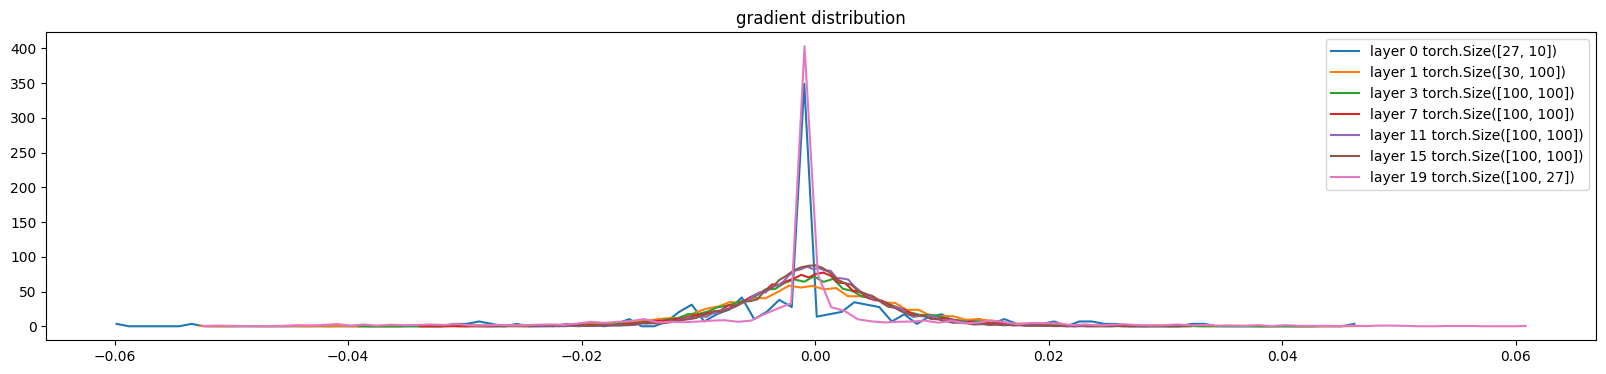

In [28]:
# visualize histograms for all weights

plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('layer {} ({}): mean {}, std {}, grad:data raptio {}'.format(i, p.shape, t.mean(), t.std(), (t/p).abs().mean()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append('layer {} {}'.format(i, p.shape))
plt.legend(legends)
plt.title('gradient distribution')

Text(0.5, 1.0, 'update_to_data_ratio')

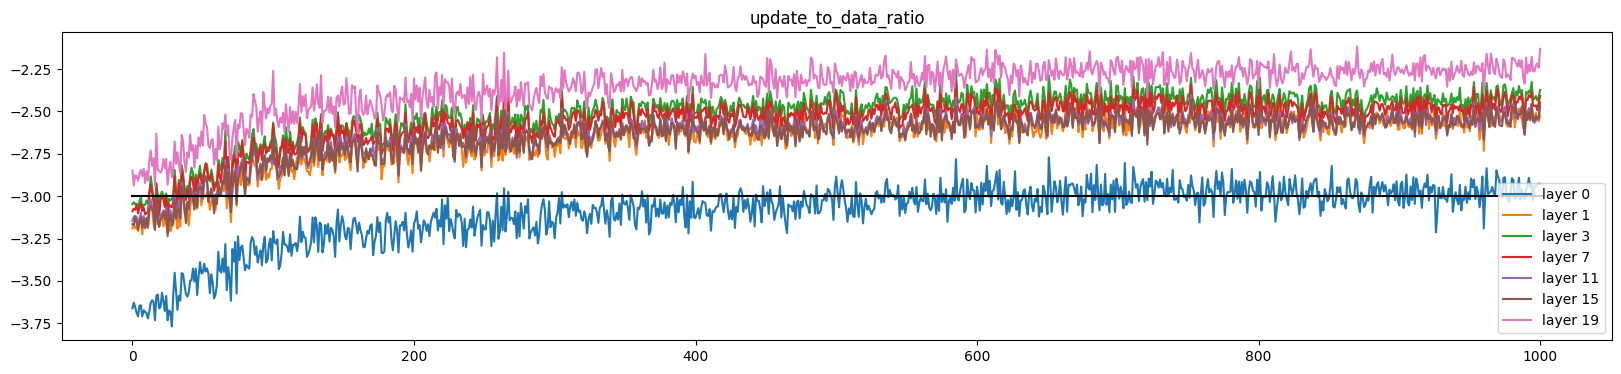

In [29]:
# visualize update_to_data_ratio
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([update_to_data_ratio[j][i] for j in range(len(update_to_data_ratio))])
    legends.append('layer {}'.format(i))
plt.plot([0, len(update_to_data_ratio)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
# if it is below this ratio, learning rate is too low
plt.legend(legends)
plt.title('update_to_data_ratio')

In [ ]:
# the above felt like balancing, calibrating too may things.
# that can be hard.
# let us know introduce BatchNorm

In [ ]:
# evaluation

@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embed)
  emb_cat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
  for layer in layers:
    emb_cat = layer(emb_cat)
  loss = F.cross_entropy(emb_cat, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')